In [2]:
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import setGPU
from importlib import reload
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
sys.path.append(os.path.abspath(os.path.join('../../')))
import vande.analysis.analysis_roc as ar

setGPU: Setting GPU to: 0


In [3]:
import models.models as models
reload(models)
import models.losses as losses
reload(losses)
import utils.preprocessing as prepr
reload(prepr)

Using TensorFlow backend.


<module 'utils.preprocessing' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/preprocessing.py'>

In [ ]:
#Data Samples
#DATA_PATH = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/'

#TRAIN_NAME = 'qcd_sqrtshatTeV_13TeV_PU40_NEW_sideband'
#filename_bg = DATA_PATH + TRAIN_NAME + '_parts/' + TRAIN_NAME + '_000.h5'
#batch_size = 128
#train_set_size = int((5*10e5//batch_size)*batch_size)
#_,_, particles_bg = prepr.prepare_data_constituents(filename_bg,train_set_size,0,train_set_size+1)

In [4]:
DATA_PATH = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/input/'
filename_bg = DATA_PATH + 'QCD_training_data_02_08_2021.h5'
inFile = h5py.File(filename_bg, 'r')
particles_bg = inFile['particle_bg'][0:int(5*10e4)]
particles_bg_valid = inFile['particle_bg_valid'][0:int(1*10e4)]
particles_bg_test = inFile['particle_bg_test'][0:int(1*10e4)]
nodes_n = particles_bg.shape[1]
feat_sz = particles_bg.shape[2]

In [7]:
#signal
DATA_PATH = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/'
SIG_MASS = '3.5'
SIG_NAME = 'RSGraviton_WW_NARROW_13TeV_PU40_'+SIG_MASS+'TeV_NEW'
filename_sig = DATA_PATH + SIG_NAME + '_parts/' + SIG_NAME + '_concat_001.h5'
_,_, particles_sig = prepr.prepare_data_constituents(filename_sig,5000,0,5000)

Number of jets = 9966
Number of constituents (nodes) = 50
Number of features = 3


In [8]:
_,_, particles_sig_2 = prepr.prepare_data_constituents(filename_sig.replace("NARROW","BROAD").replace("3.5","1.5"),5000,0,5000)

Number of jets = 9890
Number of constituents (nodes) = 50
Number of features = 3


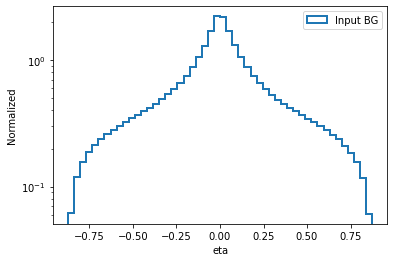

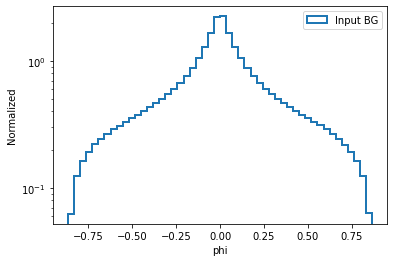

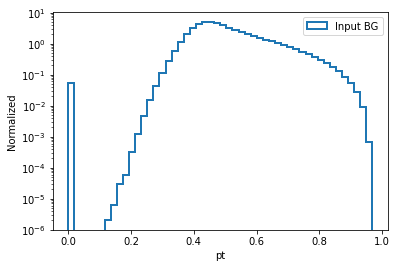

In [9]:
feats = 'eta,phi,pt'.split(',')
for i in range(0,3):
    xmin = np.quantile(particles_bg[:,:,i].flatten(),0.05)
    xmax = np.quantile(particles_bg[:,:,i].flatten(),0.98)
    plt.figure()
    plt.hist(particles_bg[:,:,i].flatten(), bins=50, label='Input BG', density=True, histtype='step', fill=False, linewidth=2)
    plt.xlabel(feats[i])
    plt.ylabel("Normalized")
    plt.legend(loc='upper right')
    plt.semilogy()
    plt.show()

In [10]:
import tensorflow.keras.layers as klayers
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

import models.losses as losses
reload(losses)
import models.models as models
reload(models)
import models.layers as layers
reload(layers)
import models.custom_functions as funcs
reload(funcs)
import models.ParticleNetAE as pnae
reload(pnae)

<module 'models.ParticleNetAE' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/models/ParticleNetAE.py'>

# Particle Net AE

In [50]:
class _DotDict:
    pass

setting = _DotDict()
 # conv_params: list of tuple in the format (K, (C1, C2, C3))
setting.conv_params = [
        (7, (8, 12, 18)),
        (20, (25, 40, 64)),
#        (7, (32, 32, 32)),
#        (7, (64, 64, 64)),
        ]
setting.conv_params_decoder = [32,16,8, 5]
# conv_pooling: 'average' or 'max'
setting.conv_pooling = 'average'
setting.conv_linking = 'concat' #concat or sum
setting.num_points = nodes_n #num of original consituents
setting.num_features = feat_sz #num of original features
setting.input_shapes = {'points': [nodes_n,feat_sz-1],'features':[nodes_n,feat_sz]}
setting.latent_dim = 3
setting.ae_type = 'ae'  #ae or vae 
setting.beta_kl = 10
setting.kl_warmup_time = 3
setting.activation = klayers.LeakyReLU(alpha=0.3)


In [51]:
model = pnae.PNVAE(setting=setting,name='PN_AE_')


Model: "ParticleNetBase"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
points (InputLayer)             [(None, 50, 2)]      0                                            
__________________________________________________________________________________________________
features (InputLayer)           [(None, 50, 3)]      0                                            
__________________________________________________________________________________________________
tf_op_layer_Transpose_12 (Tenso [(None, 2, 50)]      0           points[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_ExpandDims_30 (Tens [(None, 50, 1, 3)]   0           features[0][0]                   
____________________________________________________________________________________

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 3)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1600)              6400      
_________________________________________________________________
PN_AE__dense_0 (BatchNormali (None, 1600)              6400      
_________________________________________________________________
PN_AE__act_0 (Activation)    (None, 1600)              0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 50, 32)            0         
_________________________________________________________________
tf_op_layer_ExpandDims_37 (T [(None, 50, 1, 32)]       0         
_________________________________________________________________
PN_AE__conv_1 (Conv2D)       (None, 50, 1, 16)         512 

In [52]:
optim = Adam(learning_rate=0.001)

model.compile(optimizer=optim)

# early stopping callback
es = EarlyStopping(monitor='val_loss', patience=10)

# Learning rate scheduler 
ls = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10)

kl_beta_callback = models.KLWarmupCallback()   


history = model.fit((particles_bg[:50000,:,0:2], particles_bg[:50000,:,:]) ,  particles_bg[:50000,:,:],
                    validation_data = ((particles_bg_valid[:50000,:,0:2], particles_bg_valid[:50000,:,:]) , particles_bg_valid[:50000,:,:]),
                    epochs=5, 
                    batch_size=128, 
                    verbose=1,
                    callbacks=[es,ls,kl_beta_callback])

Epoch 1/5
391/391 [==============================] - 23s 59ms/step - loss: 0.0807 - val_loss: 0.0317
Epoch 2/5
391/391 [==============================] - 22s 56ms/step - loss: 0.0329 - val_loss: 0.0310
Epoch 3/5
391/391 [==============================] - 22s 56ms/step - loss: 0.0309 - val_loss: 0.0295
Epoch 4/5
391/391 [==============================] - 22s 57ms/step - loss: 0.0302 - val_loss: 0.0292
Epoch 5/5
391/391 [==============================] - 22s 56ms/step - loss: 0.0300 - val_loss: 0.0292


In [40]:
#models_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/'
#model_path = models_dir + "output_model_saved_PN_AE_2021_07_30_T_09_26"
#loaded_model = tf.keras.models.load_model(
#    model_path,
#    custom_objects={"PN_AE": pn.get_particle_net_lite_ae, "threeD_loss":losses.threeD_loss}
#)

#weights_path = models_dir +'PN_AE_weights_2021_07_29_T_18_19.25-0.023.hdf5'
#loaded_model.load_weights(
#    weights_path, by_name=True, skip_mismatch=False)

In [53]:
#model = loaded_model

_,Y_bg_predict = model.predict([particles_bg_test[:,:,0:2],particles_bg_test])
_,Y_sig_predict = model.predict([particles_sig[:,:,0:2],particles_sig])
_,Y_sig_predict_2 = model.predict([particles_sig_2[:,:,0:2],particles_sig_2])

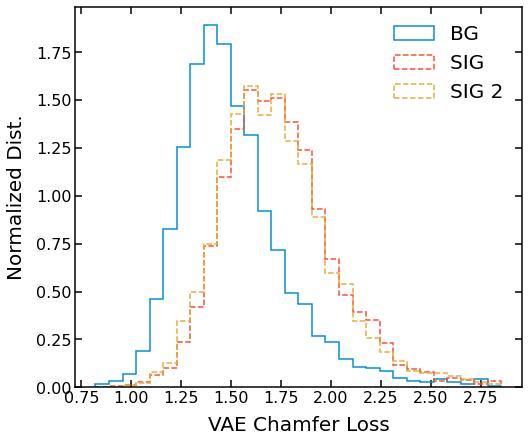

In [54]:
loss_bg = losses.threeD_loss_manual(particles_bg_test,Y_bg_predict)
loss_sig = losses.threeD_loss_manual(particles_sig,Y_sig_predict)
loss_sig_2 = losses.threeD_loss_manual(particles_sig_2,Y_sig_predict_2)

#loss_bg = losses.mse_loss_manual(particles_bg_test,Y_bg_predict)
#loss_sig = losses.mse_loss_manual(particles_sig,Y_sig_predict)


plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')

max_score = np.quantile(loss_sig,0.99)#,np.max(loss_bg_dist))
min_score = np.min(loss_bg)#,np.max(loss_bg_dist))
bins = 30
# plot BG
plt.figure()
plt.hist(loss_bg, bins=bins, label='BG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=1.5)
plt.hist(loss_sig, bins=bins, label='SIG ', density=True, range=(min_score, max_score), 
         histtype='step', linestyle='--',fill=False, linewidth=1.5)
plt.hist(loss_sig_2, bins=bins, label='SIG 2', density=True, range=(min_score, max_score), 
         histtype='step', linestyle='--',fill=False, linewidth=1.5)
#plt.semilogy()
plt.xlabel("VAE Chamfer Loss")
plt.ylabel("Normalized Dist.")
plt.legend(loc='upper right')
savename = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/figs/reco_edgeconv_pn_vae.pdf'
plt.savefig(savename)
plt.show()

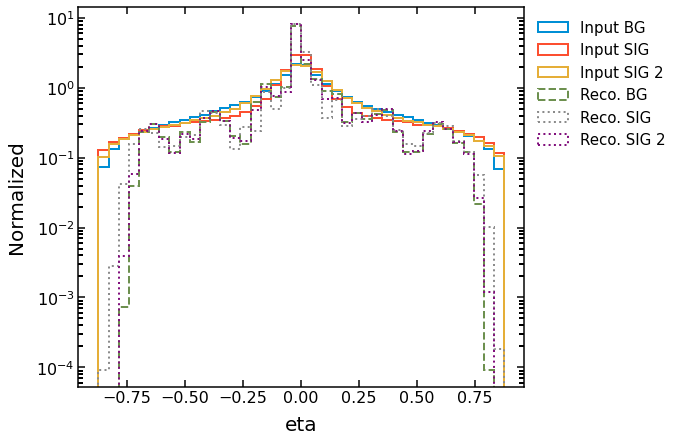

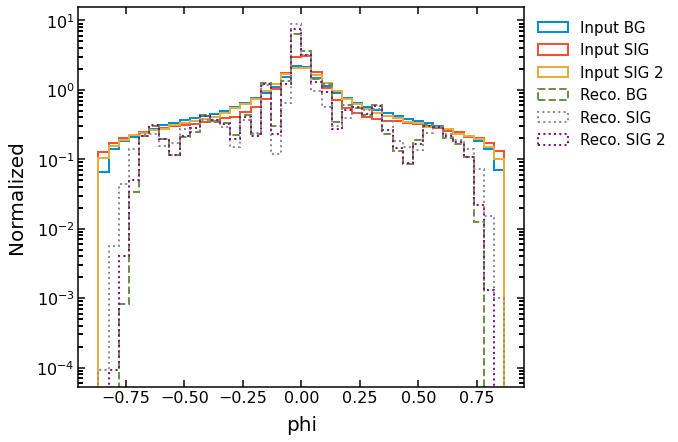

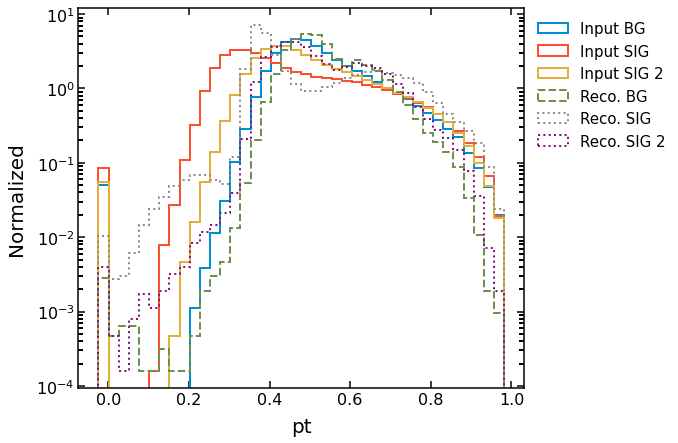

In [55]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
for i in range(0,len(feats)):
    #xmin = np.quantile(particles_bg[:,:,i].flatten(),0.)
    #xmax = np.quantile(particles_bg[:,:,i].flatten(),1)
    xmin = np.min([np.min(particles_bg[:,:,i].flatten()),np.min(Y_bg_predict[:,:,i].flatten())])
    xmax = np.max([np.max(particles_bg[:,:,i].flatten()),np.max(Y_bg_predict[:,:,i].flatten())])
    n_bins = 40
    plot_range = (xmin,xmax)
    plt.figure()
    _,bins,_ = plt.hist(particles_bg_test[:,:,i].flatten(), bins=n_bins, range = plot_range,label='Input BG', density=True, histtype='step', fill=False, linewidth=2)
    _,_,_ = plt.hist(particles_sig[:,:,i].flatten(), bins=bins, label='Input SIG',density=True, histtype='step', fill=False, linewidth=2)
    _,_,_ = plt.hist(particles_sig_2[:,:,i].flatten(), bins=bins, label='Input SIG 2',density=True, histtype='step', fill=False, linewidth=2) 
    _,_,_ = plt.hist(Y_bg_predict[:,:,i].flatten(), bins=bins, label='Reco. BG', linestyle='--',density=True, histtype='step', fill=False, linewidth=2)
    _,_,_ = plt.hist(Y_sig_predict[:,:,i].flatten(), bins=bins, label='Reco. SIG', linestyle=':',density=True, histtype='step', fill=False, linewidth=2)
    _,_,_ = plt.hist(Y_sig_predict_2[:,:,i].flatten(), bins=bins, label='Reco. SIG 2', linestyle=':',density=True, histtype='step', fill=False, linewidth=2)
    plt.xlabel(feats[i])
    plt.ylabel("Normalized")
    plt.legend(bbox_to_anchor=(1., 1.),fontsize=15)
    plt.semilogy()
    savename = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/figs/reco_edgeconv_pn_vae_{}.pdf'.format(feats[i])
    plt.savefig(savename)
    plt.show()

/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")
/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")


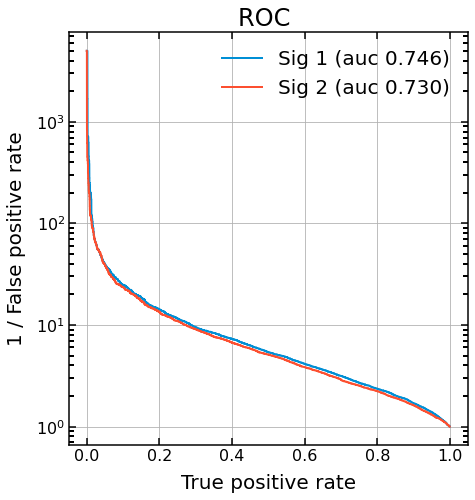

[0.74552566, 0.7298580799999999]

In [56]:
neg_class_losses = [loss_bg.tolist(),loss_bg.tolist()]
pos_class_losses = [loss_sig.tolist(),loss_sig_2.tolist()]

plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
ar.plot_roc( neg_class_losses, pos_class_losses, legend=['Sig 1','Sig 2'], title='ROC ',
            plot_name='ROC_pnae_test', fig_dir='/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/figs/',log_x=False )


In [56]:
#dataset= tf.data.Dataset.from_tensor_slices((particles_bg[:,:,0:2], particles_bg))
